In [99]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nltk.download('punkt')  #punkt is a pretrained tokenizer model

[nltk_data] Downloading package punkt to C:\Users\Aayush
[nltk_data]     Bhadani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Load Model
model = 'facebook/bart-large-mnli'
device = 0 if torch.cuda.is_available() else 'cpu'

In [4]:
def load_model(device,model):
    classifier = pipeline('zero-shot-classification',model=model,device=device)
    return classifier

In [5]:
theme_classifier = load_model(device,model)

d:\Purdue_fall24\Dev\tv-series-analysis\.venv\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Aayush Bhadani\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
d:\Purdue_fall24\Dev\tv-series-analysis\.venv\Lib\site-packages\transformers\tokeniza

In [6]:
list_of_themes = ['friendship','hope','sacrifice','battle','self development','betrayal','love','diglogue']

In [9]:
text_ip = "I gave him a right hook and then a left jab"

In [10]:

theme_classifier(text_ip,list_of_themes,multi_label=True)

{'sequence': 'I gave him a right hook and then a left jab',
 'labels': ['battle',
  'self development',
  'diglogue',
  'hope',
  'sacrifice',
  'betrayal',
  'love',
  'friendship'],
 'scores': [0.9230815172195435,
  0.5007118582725525,
  0.25550124049186707,
  0.07218195497989655,
  0.04810637608170509,
  0.020207658410072327,
  0.00610642833635211,
  0.002764083445072174]}

In [12]:
# Load dataset
files = glob('../data/naruto_subtitles/*.ass')

In [14]:
files[:5]

['../data/naruto_subtitles\\Naruto Season 1 - 01.ass',
 '../data/naruto_subtitles\\Naruto Season 1 - 02.ass',
 '../data/naruto_subtitles\\Naruto Season 1 - 03.ass',
 '../data/naruto_subtitles\\Naruto Season 1 - 04.ass',
 '../data/naruto_subtitles\\Naruto Season 1 - 05.ass']

In [22]:
with open(files[0],'r') as f:
    lines = f.readlines()
    lines = lines[27:]
    lines = [",".join(l.split(',')[9:]) for l in lines]

In [23]:
lines[:5]

['A long time ago, a powerful demon fox\\Nappeared with nine tails.\n',
 'With its powerful tails,\n',
 'it could smash mountains\\Nand create tidal waves.\n',
 'A band of Ninjas rose to\\Ndefend their village from attack.\n',
 'We have to wait until\\Nthe Fourth Hokage gets here!\n']

In [24]:
lines = [l.replace('\\N',' ') for l in lines]
lines[:5]

['A long time ago, a powerful demon fox appeared with nine tails.\n',
 'With its powerful tails,\n',
 'it could smash mountains and create tidal waves.\n',
 'A band of Ninjas rose to defend their village from attack.\n',
 'We have to wait until the Fourth Hokage gets here!\n']

In [ ]:
" ".join(lines[:10])    

# we feed this type of text to theme classifier NN. theme_classifier has max of 512 i/p tokens, we cannot feed the entire text at once and thus have to divide it into batches.

"A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can't let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known asâ€¦ the Fourth Hokage.\n Naruto!\n"

In [30]:
episode_num = int(files[0].split('-')[-1].split('.')[0].strip())

In [51]:
def load_subtitles_dataset(dataset_path):
    files = glob(dataset_path+'/*.ass')
    scripts = []
    episode_nums = []
    for file in files:
        with open(file,'r',encoding='utf-8') as f:
            lines = f.readlines()
            lines = lines[27:]
            lines = [",".join(l.split(',')[9:]) for l in lines]
        lines = [l.replace('\\N',' ') for l in lines]
        script = " ".join(lines)
        episode_num = int(file.split('-')[-1].split('.')[0].strip())
        scripts.append(script)
        episode_nums.append(episode_num)

    df = pd.DataFrame({'episode':episode_nums, 'script':scripts})
    return df

In [52]:
dataset_path = '../data/naruto_subtitles/' 
df = load_subtitles_dataset(dataset_path)

In [53]:
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."
...,...,...
213,216,"Summoning Jutsu!\n Oh, long time no see.\n We ..."
214,217,Gaara.\n Kankuro.\n Gaara.\n Primary Lotus!\n ...
215,218,To think the Leaf’s reinforcements will be you...
216,219,"Fly into the wavy and twisted sky, into your h..."


In [ ]:
script = df.iloc[0]['script']
script
#need to split script to fit 512 tokensize of our BART model 

'A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can\'t let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n Why did you do such a thing?!\n You\'re really gonna get it this time!\n I don\'t care!\n You know your problem?\n You can\'t do the things I do!\n Only I can do this!\n I\'m better than all of you! Believe it!\n There\'s a problem, sir!\n Lord Hokage!\n What is it?\n Did that Naruto do something again?\n Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them!\n Wait!\n Ha ha…\n Why should I?\n Hey, Naruto!\n How did you suddenly get here, lruka Sensei?\n The question is what are you doing here when you should 

In [57]:
script_sentences = sent_tokenize(script)
script_sentences[:5]

['A long time ago, a powerful demon fox appeared with nine tails.',
 'With its powerful tails,\n it could smash mountains and create tidal waves.',
 'A band of Ninjas rose to defend their village from attack.',
 'We have to wait until the Fourth Hokage gets here!',
 "We can't let it get any closer to our village!"]

In [58]:
# Batch sentence
sent_batch_size = 20
script_batches_list = []
for i in range(0,len(script_sentences),sent_batch_size):
    sent = " ".join(script_sentences[i:i+sent_batch_size])
    script_batches_list.append(sent)

In [59]:
script_batches_list[:2]

["A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
 'Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here, lruka Sensei? The question is what are you doing here when you should be in class now? Now listen, Naruto. You failed t

In [60]:
# Run model
theme_op = theme_classifier(script_batches_list[:2],list_of_themes,multi_label=True)
#we can run model on multiple inputs at one time by giving it a list of input sentences

In [61]:
theme_op

[{'sequence': "A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
  'labels': ['betrayal',
   'battle',
   'sacrifice',
   'self development',
   'diglogue',
   'hope',
   'friendship',
   'love'],
  'scores': [0.9396899938583374,
   0.8546878099441528,
   0.7349792122840881,
   0.7284933924674988,
   0.2275494635105133,
   0.199098512530326

In [62]:
# Wrangle output
themes = {}
for op in theme_op:
    for label,score in zip(op['labels'],op['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)


In [63]:
themes

{'betrayal': [0.9396899938583374, 0.645724356174469],
 'battle': [0.8546878099441528, 0.6581308841705322],
 'sacrifice': [0.7349792122840881, 0.6258835196495056],
 'self development': [0.7284933924674988, 0.8678195476531982],
 'diglogue': [0.2275494635105133, 0.2865266799926758],
 'hope': [0.19909851253032684, 0.20424096286296844],
 'friendship': [0.05922350287437439, 0.08603237569332123],
 'love': [0.04026192054152489, 0.02802066132426262]}

In [70]:
{key:np.mean(np.array(val)) for key,val in themes.items()}

{'betrayal': np.float64(0.7927071750164032),
 'battle': np.float64(0.7564093470573425),
 'sacrifice': np.float64(0.6804313659667969),
 'self development': np.float64(0.7981564700603485),
 'diglogue': np.float64(0.25703807175159454),
 'hope': np.float64(0.20166973769664764),
 'friendship': np.float64(0.07262793928384781),
 'love': np.float64(0.03414129093289375)}

In [71]:
def get_inference(script):
    script_sentences = sent_tokenize(script)
    #batch sentence
    sent_batch_size = 20
    script_batches_list = []
    for i in range(0,len(script_sentences),sent_batch_size):
        sent = " ".join(script_sentences[i:i+sent_batch_size])
        script_batches_list.append(sent)
    #run model
    theme_op = theme_classifier(script_batches_list[:2],list_of_themes,multi_label=True)
    # wrangle output
    themes = {}
    for op in theme_op:
        for label,score in zip(op['labels'],op['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)
    themes = {key:np.mean(np.array(val)) for key,val in themes.items()}
    return themes

In [77]:
df_example = df[:2]
op_example = df_example['script'].apply(get_inference)

In [85]:
theme_df_example = pd.DataFrame(op_example.tolist())
theme_df_example

,betrayal,battle,sacrifice,self development,diglogue,hope,friendship,love
0,0.792707,0.756409,0.680431,0.798156,0.257038,0.201670,0.072628,0.034141
1,0.429944,0.684843,0.570703,0.482808,0.219067,0.154534,0.046261,0.173262


In [88]:
df_example

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [89]:
df_example[theme_df_example.columns] = theme_df_example
df_example

C:\Users\Aayush Bhadani\AppData\Local\Temp\ipykernel_11948\1910438276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_example[theme_df_example.columns] = theme_df_example
C:\Users\Aayush Bhadani\AppData\Local\Temp\ipykernel_11948\1910438276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_example[theme_df_example.columns] = theme_df_example
C:\Users\Aayush Bhadani\AppData\Local\Temp\ipykernel_11948\1910438276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

,episode,script,betrayal,battle,sacrifice,self development,diglogue,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.792707,0.756409,0.680431,0.798156,0.257038,0.201670,0.072628,0.034141
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.429944,0.684843,0.570703,0.482808,0.219067,0.154534,0.046261,0.173262


In [96]:
#Plot op

df = df_example.drop(['episode','script'],axis=1).sum().reset_index()
df.columns = ['theme','score']
df


,theme,score
0,betrayal,1.222652
1,battle,1.441253
2,sacrifice,1.251134
3,self development,1.280964
4,diglogue,0.476105
5,hope,0.356204
6,friendship,0.118888
7,love,0.207403


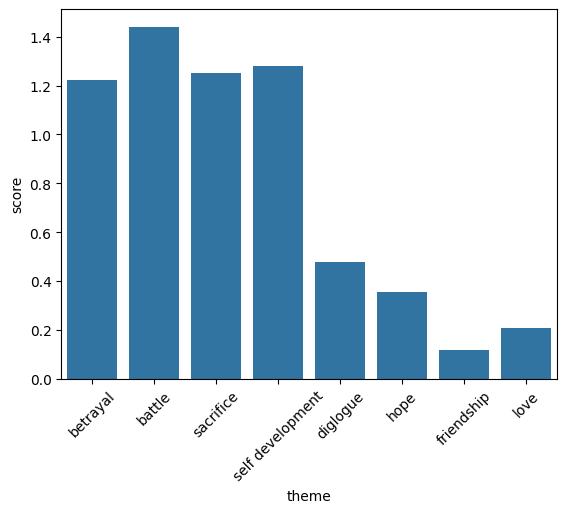

In [105]:
sns.barplot(df,x="theme",y='score')
plt.xticks(rotation=45)
plt.show()